# <center> Практика. Оптимизация гиперпараметров модели

## <center> Предсказание биологического ответа молекул по их химическому составу

### Постановка задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776). Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [ ]:
# Устанавливаем библиотеки
!pip install hyperopt
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.4/602.4 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score #кросс-валидация

# Библиотеки для оптимизации гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import optuna

# Скрываем warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

%matplotlib inline
plt.style.use('seaborn-v0_8')

### Знакомство с данными

In [ ]:
# Скачиваем датасет с Google диска
!wget "https://drive.google.com/uc?export=download&id=16XN1UyY2dN5ffE8thy08zMQUQ5DJcITz" -O _train_sem09.csv

--2025-02-17 16:39:51--  https://drive.google.com/uc?export=download&id=16XN1UyY2dN5ffE8thy08zMQUQ5DJcITz
Resolving drive.google.com (drive.google.com)... 74.125.126.100, 74.125.126.113, 74.125.126.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.126.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=16XN1UyY2dN5ffE8thy08zMQUQ5DJcITz&export=download [following]
--2025-02-17 16:39:52--  https://drive.usercontent.google.com/download?id=16XN1UyY2dN5ffE8thy08zMQUQ5DJcITz&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.125.132, 2607:f8b0:4001:c2f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18623278 (18M) [application/octet-stream]
Saving to: ‘_train_sem09.csv’

_train_sem09.csv    100%[===================>]  17.76M  43.0

In [ ]:
data = pd.read_csv('/content/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Предварительная обработка не требуется, данные уже закодированы и нормализованы.

Смотрим на сбалансированность классов:

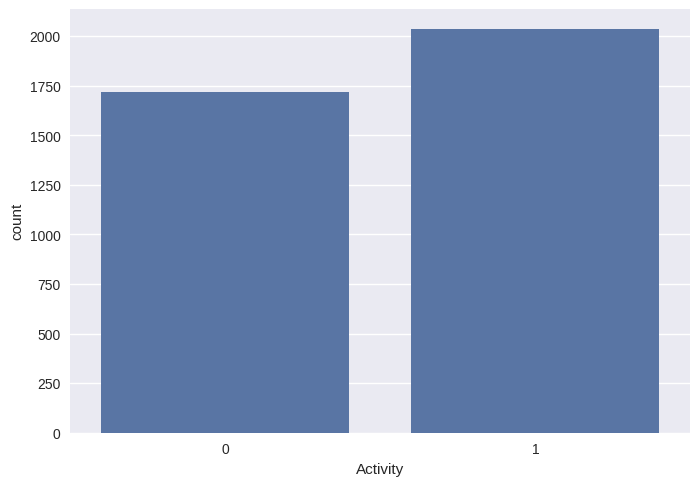

In [ ]:
sns.countplot(data=data, x='Activity');

Будем считать данные сбалансированными.

Создаем матрицу наблюдений X и вектор ответов y

In [ ]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state = 42, test_size = 0.2)

### Оптимизация гиперпараметров модели

Зафиксируем метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию

#### Логистическая регрессия

In [ ]:
# зафксируем random_state
random_state = 42

#Создаем объект класса логистическая регрессия
# максимальное количество итераций не должно превышать 50,
log_reg = linear_model.LogisticRegression(
    max_iter = 50, random_state=random_state)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.88
f1_score на тестовом наборе: 0.78


#### Случайный лес

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('f1_score на тренировочном наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 1.00
f1_score на тестовом наборе: 0.81


Для модели случаного леса мы наблюдаем переобучение.

### <center> GridSearchCV

#### Логистическая регрессия

In [ ]:
# Составим сетку гиперпараметров
param_grid = [
    {'penalty': ['l2', None] , # тип регуляризации
     'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
     'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
    {'penalty': ['l1', 'l2'] ,
     'solver': ['liblinear', 'saga'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]
# Создадим объект класса GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state, max_iter=50),
    param_grid=param_grid,
    cv=5, # кросс-валидация
    scoring='f1', # поменяем score-функцию согласно условию задания
    n_jobs = -1
)

# Замеряем время
%time grid_search_lr.fit(X_train, y_train)
y_train_pred = grid_search_lr.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(
    grid_search_lr.best_params_))

CPU times: user 6.78 s, sys: 492 ms, total: 7.27 s
Wall time: 2min 55s
f1_score на тренировочном наборе: 0.84
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.34, 'penalty': 'l1', 'solver': 'saga'}


Целевую метрику не удалось улучшить на тестовой выборке.

In [ ]:
print("Наилучшая модель:\n{}".format(grid_search_lr.best_estimator_))

Наилучшая модель:
LogisticRegression(C=0.34, max_iter=50, penalty='l1', random_state=42,
                   solver='saga')


In [ ]:
print("Наилучшее значение f1-score при кросс-валидаци: {:.2f}".format(
    grid_search_lr.best_score_))

Наилучшее значение f1-score при кросс-валидаци: 0.79


In [ ]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_lr.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.34152,0.041368,0.014913,0.000464,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.816568,0.793846,0.769006,0.792342,0.768769,0.788106,0.017887,6
1,2.45554,0.036049,0.013864,0.000528,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.818316,0.793846,0.769006,0.792342,0.765766,0.787855,0.019116,9


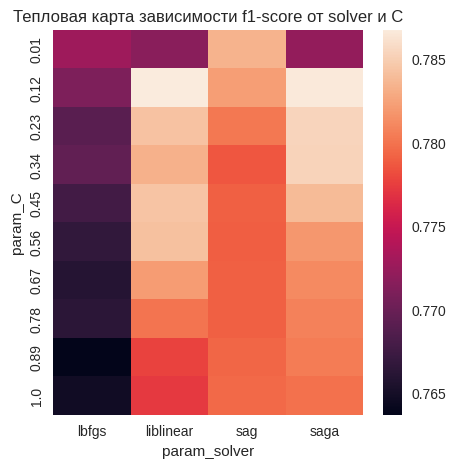

In [ ]:
# отрисуем, как менялась метрика при различных гиперпараметрах
visual = pd.pivot_table(
    pd.DataFrame(grid_search_lr.cv_results_),
    values='mean_test_score',
    index='param_C',
    columns='param_solver')
plt.figure(figsize=(5,5))
sns.heatmap(visual)
plt.title('Тепловая карта зависимости f1-score от solver и С'); # подпись графика


Худшие значения метрики наблюдаются при алгоритме оптимизации 'lbfgs' и при коэффициенте С = 0.01. Большие значения С также отрицательно влияют. Необходимо это учесть.

#### Случайный лес

In [ ]:
# Составим сетку гиперпараметров
param_grid = {'n_estimators': [100, 200, 300, 500],
              'min_samples_leaf': [1, 5, 9],
              'max_depth': [10, 15, 20, 30]}

# Создадим объект класса GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid,
    cv=5, # кросс-валидация
    scoring='f1', # поменяем score-функцию согласно условию задания
    n_jobs = -1
)

# Замеряем время
%time grid_search_rf.fit(X_train, y_train)
y_train_pred = grid_search_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(
    grid_search_rf.best_params_))

CPU times: user 4.3 s, sys: 542 ms, total: 4.84 s
Wall time: 2min 52s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}


Значение целевой метрики на тестовых данных не удалось улучшить, переобучение не ушло.

In [ ]:
print("Наилучшее значение f1-score при кросс-валидаци: {:.2f}".format(
    grid_search_rf.best_score_))

Наилучшее значение f1-score при кросс-валидаци: 0.82


In [ ]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_rf.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.966475,0.050187,0.027777,0.001152,10,1,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'n_es...",0.848120,0.813880,0.779412,0.816024,0.785162,0.808520,0.024682,28
1,1.984176,0.096094,0.037292,0.003374,10,1,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'n_es...",0.846039,0.823899,0.791176,0.820896,0.780864,0.812575,0.023583,17


Отрисуем, как менялась метрика при различных гиперпараметрах.

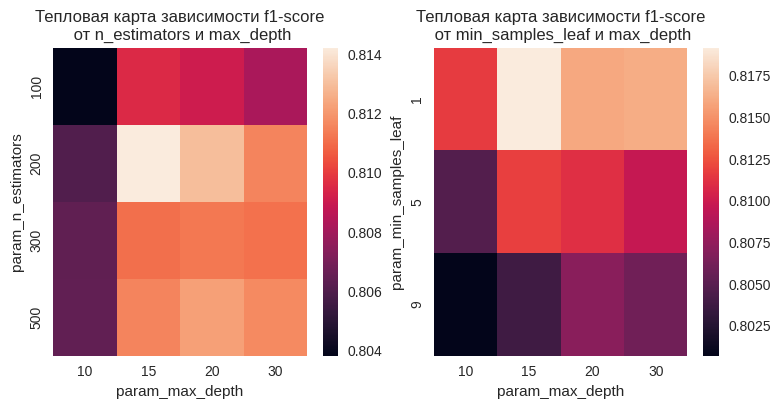

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
visual1 = pd.pivot_table(pd.DataFrame(grid_search_rf.cv_results_),
                        values='mean_test_score', index='param_n_estimators',
                        columns='param_max_depth')
#plt.figure(figsize=(5,5))
sns.heatmap(visual1, ax=axes[0])
axes[0].set_title('Тепловая карта зависимости f1-score\n от n_estimators и max_depth');

visual2 = pd.pivot_table(pd.DataFrame(grid_search_rf.cv_results_),
                        values='mean_test_score', index='param_min_samples_leaf',
                        columns='param_max_depth')
#plt.figure(figsize=(5,5))
sns.heatmap(visual2, ax=axes[1])
axes[1].set_title('Тепловая карта зависимости f1-score\n от min_samples_leaf и max_depth');

Мы видим, что меньшие значения параметров n_estimators и max_depth и большие значения min_samples_leaf дают хуже значения метрики, учтем это.

### <center> RandomizedSearchCV

#### Логистическая регрессия

In [ ]:
# Зададим сетку гиперпараметров
param_distributions = {
    'penalty': ['l1', 'l2'] ,
    'solver': ['liblinear', 'saga'],
    'C': list(np.linspace(0.1, 0.6, 20, dtype=float))}

# Создадим объект класса RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=random_state, max_iter=50),
    param_distributions=param_distributions,
    cv=5, # кросс-валидация
    scoring='f1', # поменяем score-функцию согласно условию задания
    n_iter = 30, # количество итераций
    n_jobs = -1,
    random_state=random_state
)

%time random_search_lr.fit(X_train, y_train)  # Замеряем время
y_train_pred = random_search_lr.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(
    random_search_lr.best_params_))

CPU times: user 5.87 s, sys: 275 ms, total: 6.14 s
Wall time: 1min 16s
f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.31052631578947365}


In [ ]:
print("Наилучшее значение f1-score при кросс-валидаци: {:.2f}".format(
    random_search_lr.best_score_))

Наилучшее значение f1-score при кросс-валидаци: 0.79


Метрику на тестовых данных удалось улучшить за счет скорректированной после GridSearchCV сетки гиперпараметров. Времени затратили меньше, чем с GridSearchCV.

#### Случайный лес

In [ ]:
# Зададим сетку гиперпараметров
param_distributions = {'n_estimators': [150, 200, 250, 300, 350, 400],
                       'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                       'max_depth': [15, 20, 25, 30, 35]}

# Создадим объект класса RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions,
    cv=5, # кросс-валидация
    scoring='f1', # поменяем score-функцию согласно условию задания
    n_iter = 30, # количество итераций
    n_jobs = -1,
    random_state=random_state
)

%time random_search_rf.fit(X_train, y_train) # Замеряем время
y_train_pred = random_search_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(
    y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(
    random_search_rf.best_params_))

CPU times: user 5.21 s, sys: 269 ms, total: 5.48 s
Wall time: 1min 58s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 2, 'max_depth': 25}


Метрика не улучшилась, но время затратили меньше, чем с GridSearchCV.

In [ ]:
print("Наилучшее значение f1-score при кросс-валидаци: {:.2f}".format(
    random_search_rf.best_score_))

Наилучшее значение f1-score при кросс-валидаци: 0.82


### <center> Hyperopt

#### Логистическая регрессия

In [ ]:
# зададим пространство поиска гиперпараметров
space_lr = {'penalty': hp.choice('penalty', ['l1', 'l2']), # тип регуляризации
         'solver': hp.choice('solver', ['liblinear', 'saga']), # алгоритм оптимизации
         'C':  hp.uniform('C', 0.1, 1)} # уровень силы регурялизации

In [ ]:
# Функция для минимизации
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'],
              'solver': params['solver'],
              'C': float(params['C'])
              }

    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
        **params, max_iter=50, random_state=random_state)

    #model.fit(X_train, y_train)
    # применим  cross validation
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # вернём значение метрики со знаком минус и параметры
    return {'loss': -score, 'params': params, 'status': STATUS_OK}

In [ ]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

# основная функция, она будет минимизировать наш функционал
best=fmin(hyperopt_lr,
          space=space_lr,
          algo=tpe.suggest,
          max_evals=30, # максимальное количество итераций
          trials=trials,
          rstate=np.random.default_rng(random_state)
          #rstate=np.random.RandomState(random_state) для версии 0.2.5
         )

best_params = trials.best_trial['result']['params']
print("Наилучшие значения гиперпараметров: {}".format(best_params))
#print("Наилучшие значения гиперпараметров: {}".format(hyperopt.space_eval(space, best)))

100%|██████████| 30/30 [02:59<00:00,  5.98s/trial, best loss: -0.7921745658980317]
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'saga', 'C': 0.2570498841195761}
CPU times: user 1.72 s, sys: 1.01 s, total: 2.73 s
Wall time: 2min 59s


In [ ]:
# рассчитаем f1-score для тестовой выборки
lr_hyperopt = linear_model.LogisticRegression(
    random_state=random_state,
    max_iter=50,
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    C=best_params['C']
)
lr_hyperopt.fit(X_train, y_train)
y_train_pred = lr_hyperopt.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = lr_hyperopt.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.79


F1-мера улучшилась по сравнению с изначальной, но относительно RandomizedSearchCV изменений нет.

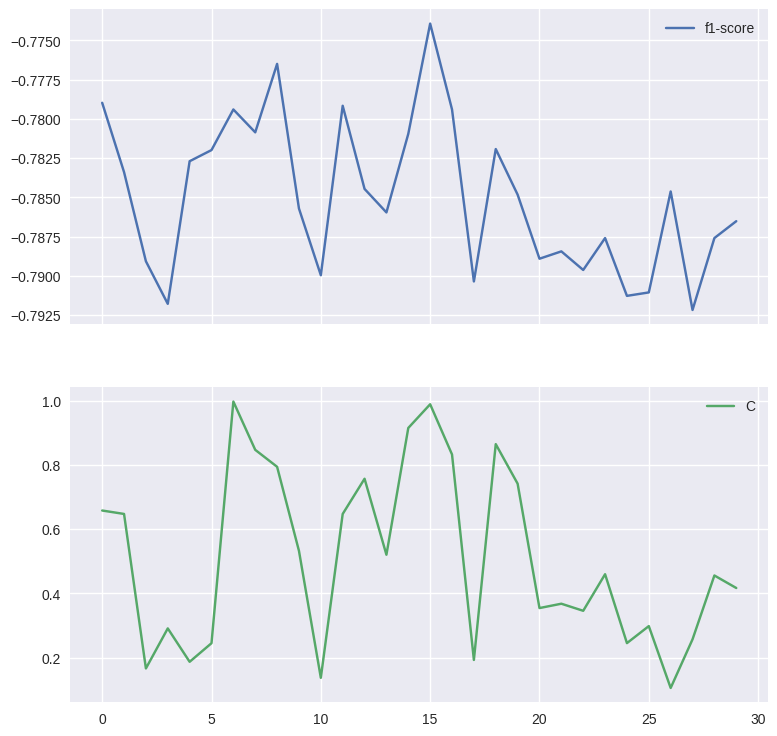

In [ ]:
# отрисуем, как менялась метрика при коэффициенте С
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['f1-score', 'C'])
# линейный график
tpe_results_df.plot(subplots=True,figsize=(9, 9));

#### Случайный лес

In [ ]:
# зададим пространство поиска гиперпараметров
space_rf={'n_estimators': hp.quniform('n_estimators', 150, 400, 10),
       'max_depth' : hp.quniform('max_depth', 15, 35, 5),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 7, 1)
      }

In [ ]:
# Функция для минимизации
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }

    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    #model.fit(X_train, y_train)
    # применим  cross validation
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
%%time
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

# основная функция, она будет минимизировать наш функционал
best=fmin(hyperopt_rf,
          space=space_rf,
          algo=tpe.suggest,
          max_evals=30, # максимальное количество итераций
          trials=trials,
          rstate=np.random.default_rng(random_state)
          #rstate=np.random.RandomState(random_state) для версии 0.2.5
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 30/30 [03:08<00:00,  6.28s/trial, best loss: -0.820857487557719]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 2.0, 'n_estimators': 400.0}
CPU times: user 1.84 s, sys: 1.01 s, total: 2.85 s
Wall time: 3min 8s


In [ ]:
# рассчитаем f1-score для тестовой выборки
rf_hyperopt = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
rf_hyperopt.fit(X_train, y_train)
y_train_pred = rf_hyperopt.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf_hyperopt.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.81


Целевая метрика не улучшилась. Также наблюдаем переобучение.

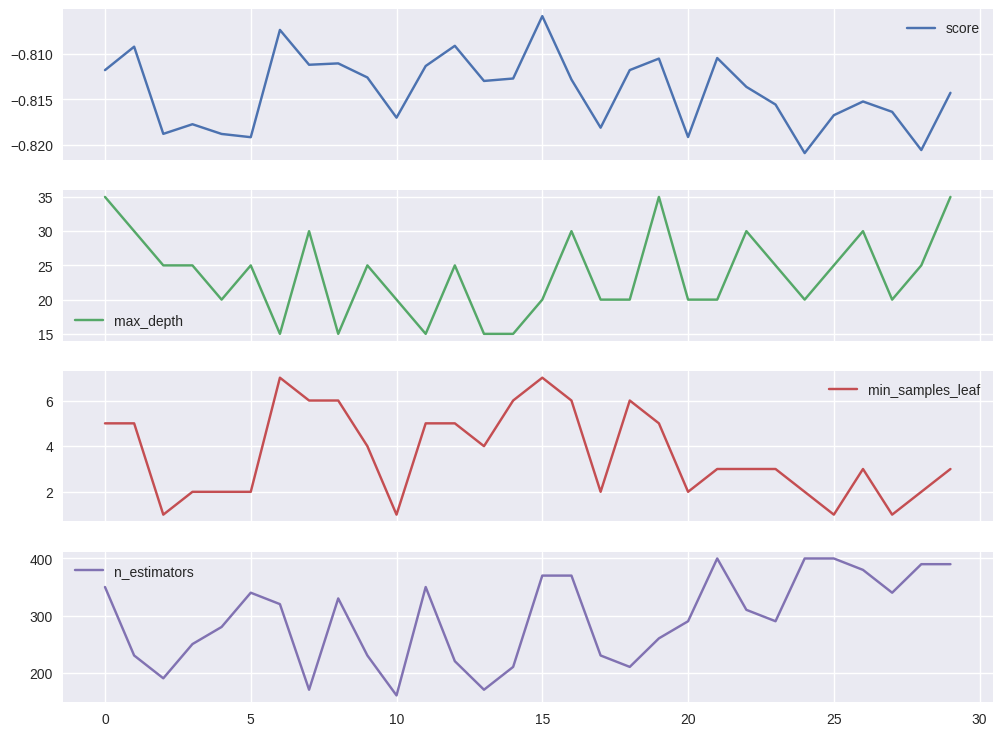

In [ ]:
# отрисуем, как менялась f1-score при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_samples_leaf'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(
    tpe_results, columns=['score', 'max_depth', 'min_samples_leaf', 'n_estimators'])
# линейный график
tpe_results_df.plot(subplots=True,figsize=(12, 9));

## <center> Optuna

#### Логистическая регрессия

In [ ]:
def optuna_lr(trial):
    # задаем пространства поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty',['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    c= trial.suggest_uniform('C', 0.1, 1)

    # создаем модель
    model = linear_model.LogisticRegression(
        max_iter=50,
        random_state=random_state,
        penalty=penalty,
        solver=solver,
        C=c
    )

    #model.fit(X_train, y_train)
    # применим  cross validation
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

    return score

In [ ]:
%%time
# cоздаем объект исследования
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=30)

[I 2025-02-17 18:09:12,811] A new study created in memory with name: LogisticRegression
[I 2025-02-17 18:09:13,896] Trial 0 finished with value: 0.7790633524291473 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.653825174922676}. Best is trial 0 with value: 0.7790633524291473.
[I 2025-02-17 18:09:25,631] Trial 1 finished with value: 0.7854700982898016 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.7294127369128849}. Best is trial 1 with value: 0.7854700982898016.
[I 2025-02-17 18:09:26,829] Trial 2 finished with value: 0.7744711953493978 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.995501124958057}. Best is trial 1 with value: 0.7854700982898016.
[I 2025-02-17 18:09:37,332] Trial 3 finished with value: 0.7874477595957011 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.32323784074869044}. Best is trial 3 with value: 0.7874477595957011.
[I 2025-02-17 18:09:38,407] Trial 4 finished with value: 0.7796015116716629 and parameters: {'p

CPU times: user 2.06 s, sys: 1.24 s, total: 3.31 s
Wall time: 4min 12s


In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.21823920843867897}
f1_score на обучающем наборе: 0.79


In [ ]:
# рассчитаем f1-score для тестовой выборки
lr_optuna = linear_model.LogisticRegression(
    **study_lr.best_params, max_iter=50, random_state=random_state)
lr_optuna.fit(X_train, y_train)
y_train_pred = lr_optuna.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = lr_optuna.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.83
f1_score на тестовом наборе: 0.78


И снова метрику не удалось улучшить.

In [ ]:
# Проверим, идет ли оптимизация гиперпараметров в правильном направлении
optuna.visualization.plot_optimization_history(study_lr, target_name="f1_score")

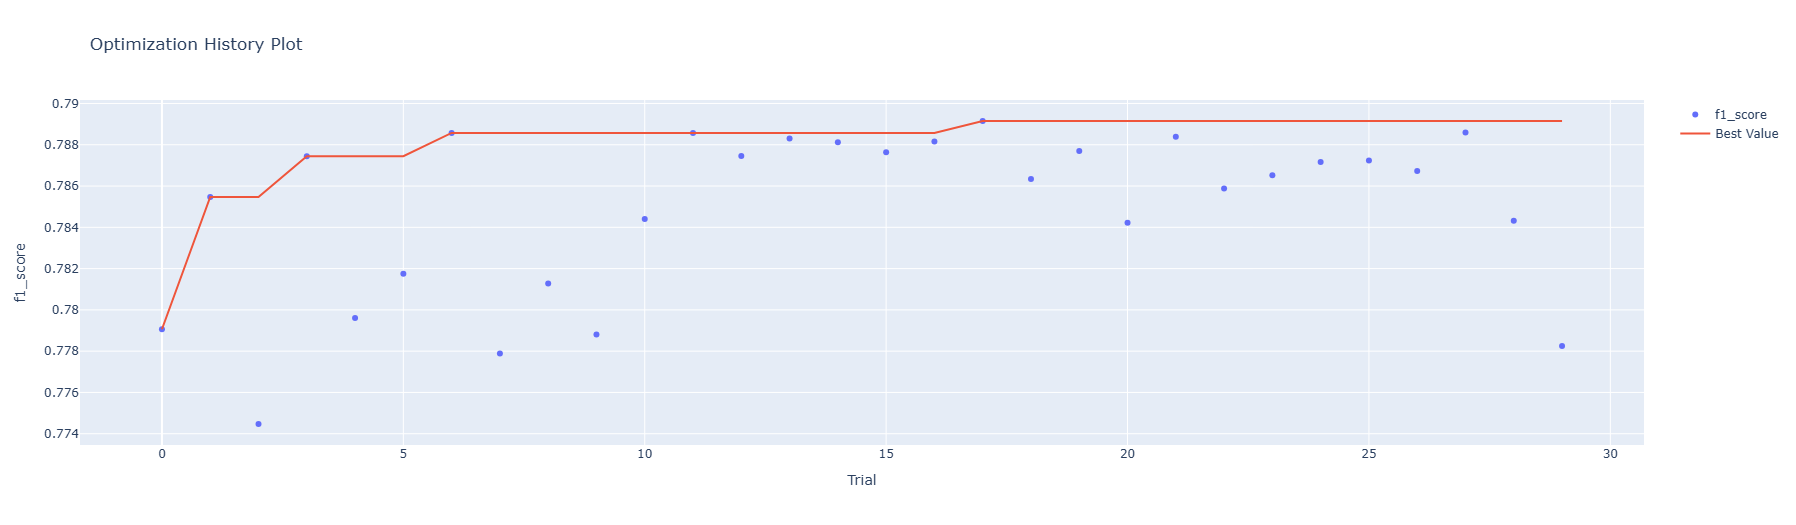

Метрика, как и задумано, максимизируется.

In [ ]:
# График важности гиперпараметров
optuna.visualization.plot_param_importances(study_lr, target_name="f1_score")

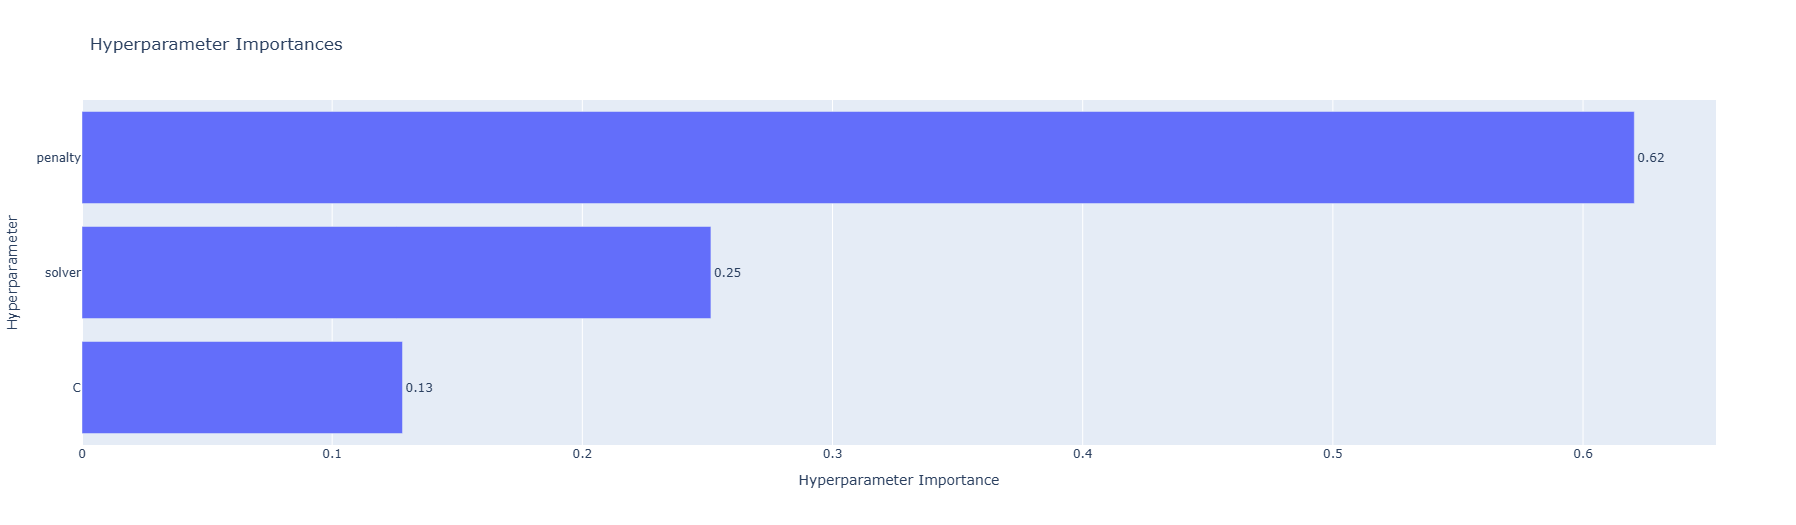

Как видно из графика, penalty вносит больший вклад в целевую метрику.

#### Случайный лес

In [ ]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 150, 400, 10)
    max_depth = trial.suggest_int('max_depth', 15, 35, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state)

    #model.fit(X_train, y_train)
    # применим  cross validation
    score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()
    #score = metrics.f1_score(y_train, model.predict(X_train))

    return score

In [ ]:
%%time
# cоздаем объект исследования
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=30)

[I 2025-02-17 18:23:05,752] A new study created in memory with name: RandomForestClassifier
[I 2025-02-17 18:23:13,885] Trial 0 finished with value: 0.8095243828009512 and parameters: {'n_estimators': 260, 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8095243828009512.
[I 2025-02-17 18:23:23,156] Trial 1 finished with value: 0.8026340371870979 and parameters: {'n_estimators': 390, 'max_depth': 30, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8095243828009512.
[I 2025-02-17 18:23:28,297] Trial 2 finished with value: 0.8077911473077306 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8095243828009512.
[I 2025-02-17 18:23:33,608] Trial 3 finished with value: 0.8079008142719264 and parameters: {'n_estimators': 200, 'max_depth': 35, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8095243828009512.
[I 2025-02-17 18:23:40,442] Trial 4 finished with value: 0.8156875861127139 and parameters: {'n_

CPU times: user 2.3 s, sys: 1.28 s, total: 3.58 s
Wall time: 3min 38s


In [ ]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 240, 'max_depth': 15, 'min_samples_leaf': 1}
f1_score на обучающем наборе: 0.82


In [ ]:
# рассчитаем f1-score для тестовой выборки
rf_optuna = ensemble.RandomForestClassifier(
    **study_rf.best_params, random_state=random_state)
rf_optuna.fit(X_train, y_train)
y_train_pred = rf_optuna.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf_optuna.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.81


Метрика не улучшилась. Переобучение не ушло.

In [ ]:
# Проверим, идет ли оптимизация гиперпараметров в правильном направлении
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

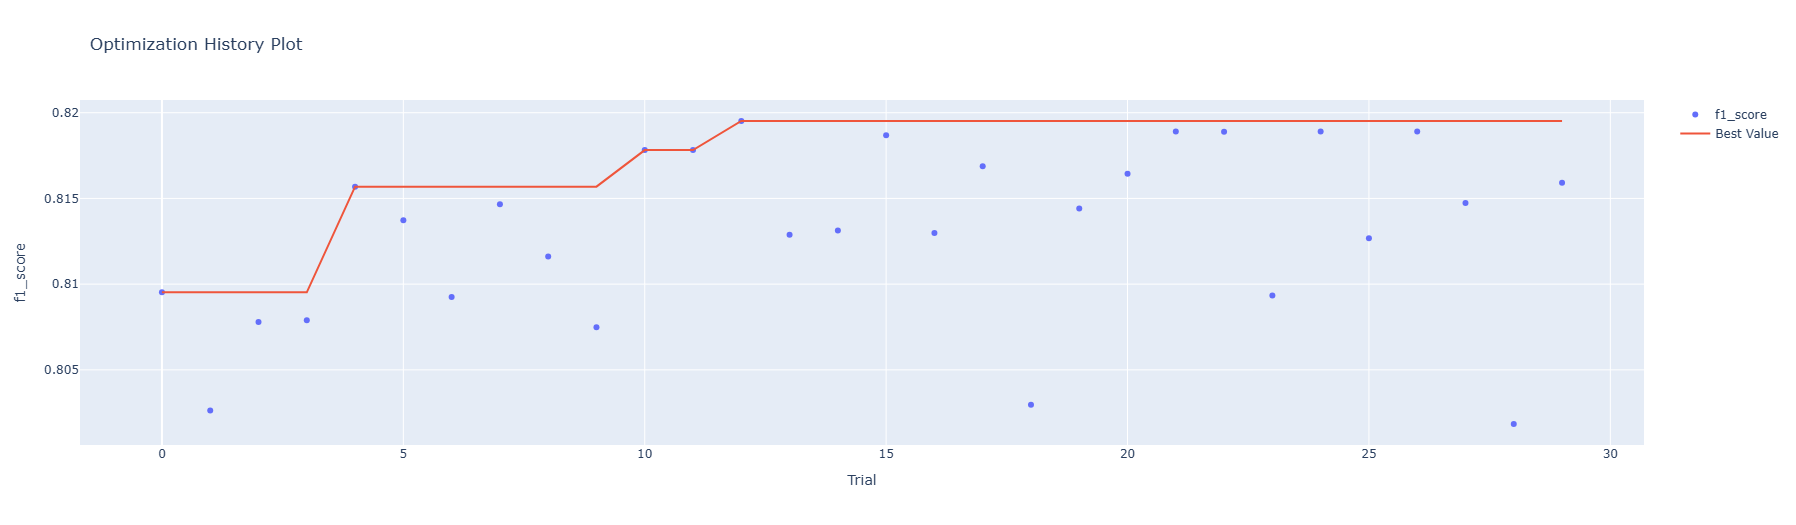

Метрика максимизируется.

In [ ]:
# График важности гиперпараметров
optuna.visualization.plot_param_importances(study_rf, target_name="f1_score")

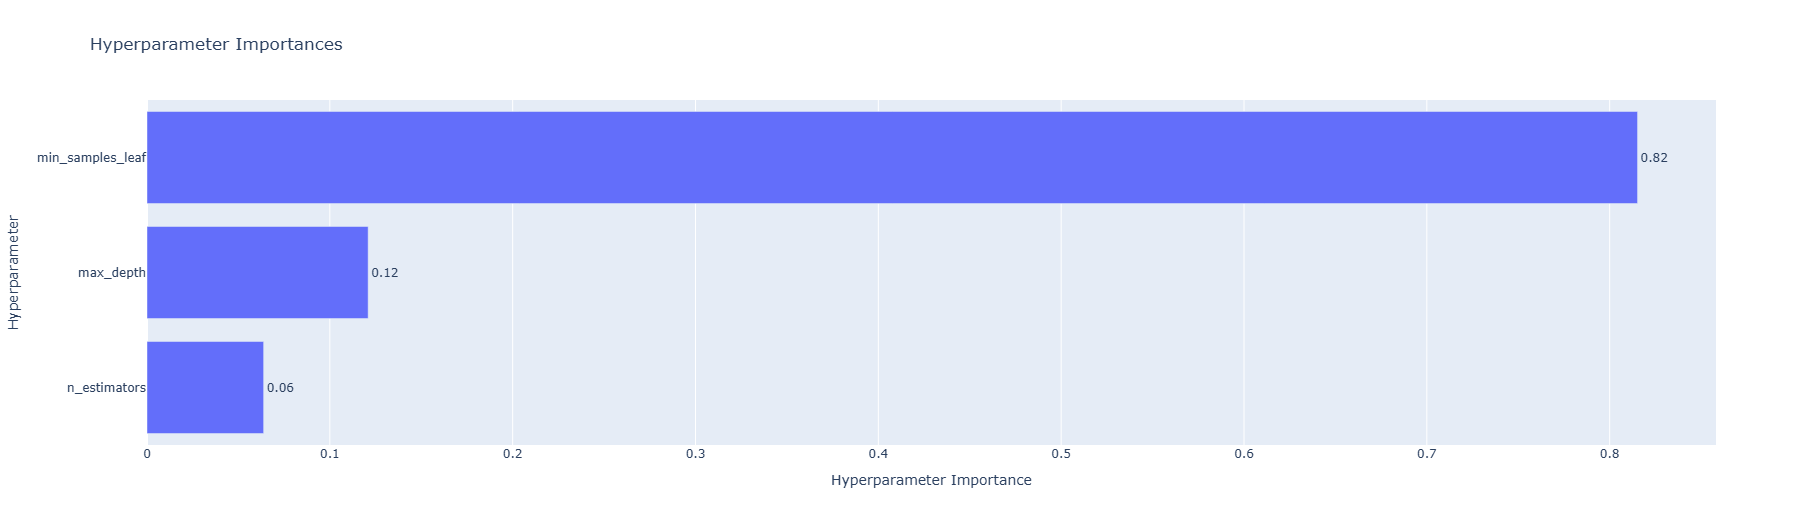

Судя по графику, больший вклад вносит min_samples_leaf.

In [ ]:
# График контура отношений гиперпараметров
optuna.visualization.plot_contour(
    study_rf, params=["max_depth", "min_samples_leaf"], target_name="f1_score")

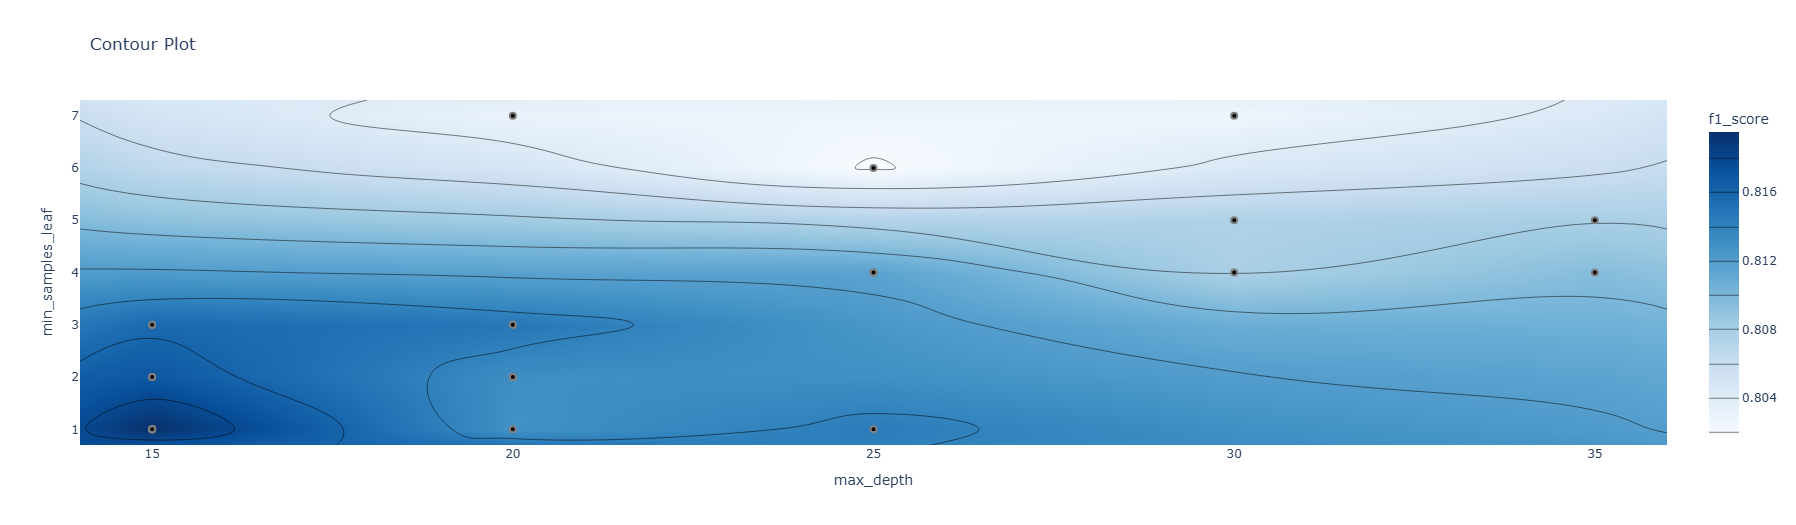

### Вывод

На примерах моделей логистической регрессии и случайного леса мы рассмотрели 2 базовых способа оптимизации гиперпараметров (GridSearchCV и RandomizedSearchCV) и 2 продвинутых (Hyperopt и Optuna). Гиперпараметры подбирались на тренировочном наборе с использованием кросс-валидации.
С помощью RandomizedSearchCV и Hyperopt удалось улучшить целевую метрику на тестовом наборе для модели логистической регрессии. Для случайного леса не удалось побороть переобучение, необходимо дополнительно скорректировать сетку гиперпараметров. Меньше всего времени на подбор гиперпараметров затратил RandomizedSearchCV.